# The k-armed bandit problem
In reinforcement learning, there is the classic k-armed bandit problem. In this problem, there are K possible actions for an agent to take, each action having some value associated with it that is unknown to the agent. It is the agent's goal to maximize value gained over a defined T number of time steps. Because the agent starts with no knowledge of the values, it must explore its options to ensure, when it exploits its knowledge, it can do so with some reasoning.

In [0]:
from random import normalvariate, randint, random, seed
seed(58)

## Action Space
The action space defines what actions an agent in this environment can take. In this case, there are K actions in an action space, with the value of each action being defined by a normal distribution.

In [0]:
class ActionSpace:
  def __init__(self, K, mu_range=[1, 10], sd_max=1):
    self.K = K
    self.dists = [(randint(mu_range[0], mu_range[1]), random() * sd_max) for _ in range(K)]
  
  def __str__(self):
    format_str = self.__repr__()
    for k in range(self.K):
      format_str += '\n\tQ[{}] = N(mu={}, sigma={:.3f})'.format(k, self.dists[k][0], self.dists[k][1])
    return format_str
  
  def get_dists(self):
    return self.dists

## Model
Each agent has a model of the values of the actions it takes. In this case, the model defines the value of an action as the average of past values.

In [0]:
class Model:
  def __init__(self, K):
    assert K > 0, 'K must be at least 1'
    
    self.K = K
    self.values = [[] for _ in range(K)]
    
  def __str__(self):
    format_str = self.__repr__()
    for k in range(self.K):
      format_str += '\n\tA[{}] = {}'.format(k, self.values[k])
    return format_str
      
  def add_value(self, action, value):
    assert action >= 0 and action < self.K, 'Action must be in range [0, {})'.format(self.K)
    self.values[action].append(value)
      
  def get_value(self, action):
    assert action >= 0 and action < self.K, 'Action must be in range [0, {})'.format(self.K)
    values = self.values[action]
    num_values = len(values)
    if num_values == 0:
      return 0
    return sum(values) / num_values

In [0]:
class IncrementalModel:
  def __init__(self, K):
    assert K > 0, 'K must be at least 1'
    
    self.K = K
    self.estimates = [0 for _ in range(K)]
    self.nums = [0 for _ in range(K)]
    
  def __str__(self):
    format_str = self.__repr__()
    for k in range(self.K):
      format_str += '\n\tA[{}] = {}'.format(k, self.estimates[k])
    return format_str
      
  def add_value(self, action, value):
    assert action >= 0 and action < self.K, 'Action must be in range [0, {})'.format(self.K)
    self.estimates[action] = (self.estimates[action] * self.nums[action] + value) / (self.nums[action] + 1)
    self.nums[action] += 1
      
  def get_value(self, action):
    assert action >= 0 and action < self.K, 'Action must be in range [0, {})'.format(self.K)
    return self.estimates[action]

## Agent
An agent has a few properties. An agent must track the value its received thus far, the number of actions taken, and a model of action values. The epsilon value of an agent defines how likely it is to explore on any given step. In this case, exploration entails selecting an action at random, regardless of previous knowledge.

In [0]:
class Agent:
  
  def __init__(self, K, eps):
    assert eps >= 0 and eps <= 1, 'Epsilon must be in the range [0, 1]'
    assert K > 0, 'K must be at least 1'
    assert isinstance(K, int), 'K must be an integer'
    
    self.eps = eps
    self.value = 0
    self.steps = 0
    self.K = K
    self.model = IncrementalModel(K)
    
  def __str__(self):
    return '{}\n\tvalue={},\n\teps={},\n\tsteps={}\n\tK={}\n\tmodel={}'.format(
      self.__repr__(), self.value, self.eps, self.steps, self.K, self.model.__str__())
  
  def get_epsilon(self):
    return self.eps
  
  def set_epsilon(self, epsilon):
    self.eps = epsilon
  
  def get_value(self):
    return self.value
  
  def take_action(self, action_space):
    dists = action_space.get_dists()
    assert len(dists) >= self.K, 'Agent cannot know more actions than exist'
    
    # Select action to take
    if random() < self.eps:  # random choice
      action = randint(0, self.K - 1)
    else:  # greedy choice
      max_value = self.model.get_value(0)
      max_value_action = 0
      for i in range(1, self.K):
        value_i = self.model.get_value(i)
        if value_i > max_value:
          max_value = value_i
          max_value_action = i
      action = max_value_action
      
    # Get value of action
    mu, sigma = dists[action]
    value = normalvariate(mu, sigma)
    
    # Update self
    self.value += value
    self.model.add_value(action, value)
    self.steps += 1
    
    return action, value

## Experiment
Let's initialize an action space and a few different agents. One agent will always take the greedy choice, another agent will make uniformly random choices, and the final agent will attempt to balance greedy and exploratory actions.

In [0]:
K = 5
action_space = ActionSpace(K=K, mu_range=[1, 10], sd_max=2)
agent = Agent(K=K, eps=0.5)
greedy_agent = Agent(K=K, eps=0)
random_agent = Agent(K=K, eps=1)

In [76]:
T = 25
for _ in range(T):
  agent.take_action(action_space)
  greedy_agent.take_action(action_space)
  random_agent.take_action(action_space)
print(action_space)
print('normal: Agent(value={})'.format(agent.get_value()))
print('greedy: Agent(value={})'.format(greedy_agent.get_value()))
print('random: Agent(value={})'.format(random_agent.get_value()))

	Q[0] = N(mu=10, sigma=0.394)
	Q[1] = N(mu=4, sigma=0.082)
	Q[2] = N(mu=8, sigma=0.811)
	Q[3] = N(mu=5, sigma=1.611)
	Q[4] = N(mu=5, sigma=1.933)
normal: Agent(value=191.86696244083606)
greedy: Agent(value=248.29656530594724)
random: Agent(value=149.70856842929214)


We can see that the greedy agent outperforms the other two agents in this case. But it looks like the greedy agent just got lucky with picking the best action first. What if we try it again?

In [0]:
K = 5
action_space = ActionSpace(K=K, mu_range=[1, 10], sd_max=2)
agent = Agent(K=K, eps=0.5)
greedy_agent = Agent(K=K, eps=0)
random_agent = Agent(K=K, eps=1)

In [78]:
T = 25
for _ in range(T):
  agent.take_action(action_space)
  greedy_agent.take_action(action_space)
  random_agent.take_action(action_space)
print(action_space)
print('normal: Agent(value={})'.format(agent.get_value()))
print('greedy: Agent(value={})'.format(greedy_agent.get_value()))
print('random: Agent(value={})'.format(random_agent.get_value()))

	Q[0] = N(mu=5, sigma=1.241)
	Q[1] = N(mu=3, sigma=0.905)
	Q[2] = N(mu=8, sigma=1.435)
	Q[3] = N(mu=7, sigma=1.269)
	Q[4] = N(mu=8, sigma=1.735)
normal: Agent(value=190.04331672224)
greedy: Agent(value=122.19357756113926)
random: Agent(value=162.65352720701765)


Here, we see that the agent that balances exploration and exploitation outperforms the other two. The greedy agent, in this case, got unlucky, picking one of the worst actions first and then sticking with it.

Let's try running our experiment 100 times.

In [79]:
N = 100
wins = {
    'normal': 0,
    'greedy': 0,
    'random': 0
}

losses = {
    'normal': 0,
    'greedy': 0,
    'random': 0
}

for n in range(N):
  K = 5
  action_space = ActionSpace(K=K, mu_range=[1, 10], sd_max=10)
  agent = Agent(K=K, eps=0.1)
  greedy_agent = Agent(K=K, eps=0)
  random_agent = Agent(K=K, eps=1)
  
  T = 10000
  for _ in range(T):
    agent.take_action(action_space)
    greedy_agent.take_action(action_space)
    random_agent.take_action(action_space)
    
  normal_value = agent.get_value()
  greedy_value = greedy_agent.get_value()
  random_value = random_agent.get_value()
  
  max_value = max(normal_value, greedy_value, random_value)
  min_value = min(normal_value, greedy_value, random_value)
  
  if max_value == normal_value:
    wins['normal'] += 1
  elif max_value == greedy_value:
    wins['greedy'] += 1
  else:
    wins['random'] += 1
    
  if min_value == normal_value:
    losses['normal'] += 1
  elif min_value == greedy_value:
    losses['greedy'] += 1
  else:
    losses['random'] += 1
print('wins', wins)
print('losses', losses)

wins {'normal': 67, 'greedy': 33, 'random': 0}
losses {'normal': 0, 'greedy': 39, 'random': 61}


We see that 67 out of the 100 times, the agent that balanced exploration and exploitation had the highest value. And notably, that agent never once had the lowest value. Also, it can be inferred from these results that the greedy agent, when it gets a lucky first pick, can get the highest value over time. However, if it chooses a poor first choice, then it can end up being worse than the other two agents.

**In the end, we can conclude that some type of learning from previous actions, even if it is basic, is beneficial to achieving the long-term goal of maximizing value.**

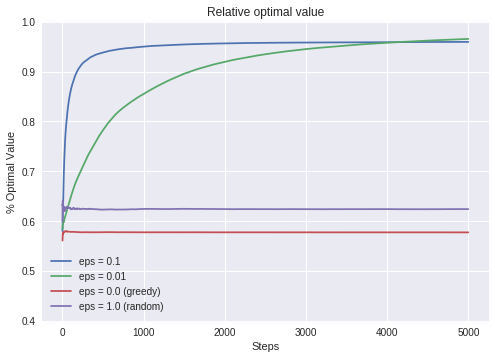

In [80]:
import matplotlib.pyplot as plt

N = 100
T = 5000
normal_pt1_steps = [0 for _ in range(T)]
normal_pt01_steps = [0 for _ in range(T)]
greedy_steps = [0 for _ in range(T)]
random_steps = [0 for _ in range(T)]

for n in range(N):
  K = 5
  
  action_space = ActionSpace(K=K, mu_range=[1, 10], sd_max=1)
  max_action_value = max(list(zip(*action_space.get_dists()))[0])
  
  normal_pt1_agent = Agent(K=K, eps=0.1)
  normal_pt01_agent = Agent(K=K, eps=0.01)
  greedy_agent = Agent(K=K, eps=0)
  random_agent = Agent(K=K, eps=1)
  
  for t in range(T):
    normal_pt1_agent.take_action(action_space)
    normal_pt1_value_percent = normal_pt1_agent.get_value() / (max_action_value * (t + 1))
    normal_pt1_steps[t] = (normal_pt1_steps[t] * n + normal_pt1_value_percent) / (n + 1)
    
    normal_pt01_agent.take_action(action_space)
    normal_pt01_value_percent = normal_pt01_agent.get_value() / (max_action_value * (t + 1))
    normal_pt01_steps[t] = (normal_pt01_steps[t] * n + normal_pt01_value_percent) / (n + 1)
    
    greedy_agent.take_action(action_space)
    greedy_value_percent = greedy_agent.get_value() / (max_action_value * (t + 1))
    greedy_steps[t] = (greedy_steps[t] * n + greedy_value_percent) / (n + 1)
    
    random_agent.take_action(action_space)
    random_value_percent = random_agent.get_value() / (max_action_value * (t + 1))
    random_steps[t] = (random_steps[t] * n + random_value_percent) / (n + 1)

plt.figure()
xs = list(range(T))
plt.plot(xs, normal_pt1_steps, label='eps = 0.1')
plt.plot(xs, normal_pt01_steps, label='eps = 0.01')
plt.plot(xs, greedy_steps, label='eps = 0.0 (greedy)')
plt.plot(xs, random_steps, label='eps = 1.0 (random)')
plt.title('Relative optimal value')
plt.xlabel('Steps')
plt.ylabel('% Optimal Value')
plt.ylim(0.4, 1)
plt.legend()
plt.show()

Even better, we can see how an agent's value approaches the optimal value when it learns. Without learning i.e. epsilon is 0 or 1, the agent does not improve upon experience. With larger epsilons, the optimal action can be found quicker, but will choose that optimal action less often. On the other hand, agents with smaller epsilons find the optimal action slower, but choose it more often once found. To get the best of both worlds, we can try reducing the epsilon over time.

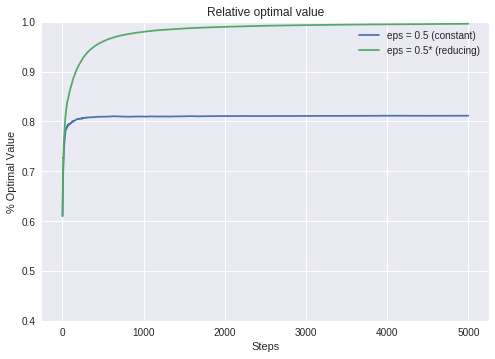

In [81]:
import matplotlib.pyplot as plt

N = 100
T = 5000
normal_pt5_steps = [0 for _ in range(T)]
reducing_pt5_steps = [0 for _ in range(T)]

for n in range(N):
  K = 5
  
  action_space = ActionSpace(K=K, mu_range=[1, 10], sd_max=1)
  max_action_value = max(list(zip(*action_space.get_dists()))[0])
  
  normal_pt5_agent = Agent(K=K, eps=0.5)
  reducing_pt5_agent = Agent(K=K, eps=0.5)
  
  for t in range(T):    
    normal_pt5_agent.take_action(action_space)
    normal_pt5_value_percent = normal_pt5_agent.get_value() / (max_action_value * (t + 1))
    normal_pt5_steps[t] = (normal_pt5_steps[t] * n + normal_pt5_value_percent) / (n + 1)
    
    reducing_pt5_agent.take_action(action_space)
    reducing_pt5_value_percent = reducing_pt5_agent.get_value() / (max_action_value * (t + 1))
    reducing_pt5_steps[t] = (reducing_pt5_steps[t] * n + reducing_pt5_value_percent) / (n + 1)
    reducing_pt5_agent.set_epsilon(reducing_pt5_agent.get_epsilon() * 0.99)
   

plt.figure()
xs = list(range(T))
plt.plot(xs, normal_pt5_steps, label='eps = 0.5 (constant)')
plt.plot(xs, reducing_pt5_steps, label='eps = 0.5* (reducing)')
plt.title('Relative optimal value')
plt.xlabel('Steps')
plt.ylabel('% Optimal Value')
plt.ylim(0.4, 1)
plt.legend()
plt.show()

Look at that! Reducing the epsilon over time made the agent perform almost perfectly! Once the agent learned what the optimal action was, it pretty much only took that action.